In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [225]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [226]:
data = pd.read_csv("/content/drive/MyDrive/NNDL/ETE3/weather_data.csv")
data.head(10)

,date,temperature
0,2014-01-01,10.248357
1,2014-01-02,9.950428
2,2014-01-03,10.362958
3,2014-01-04,10.820167
4,2014-01-05,9.961091
5,2014-01-06,9.980585
6,2014-01-07,10.906708
7,2014-01-08,10.520223
8,2014-01-09,9.921119
9,2014-01-10,10.446428


In [227]:
data.shape

(2557, 2)

In [228]:
# Parsing the date column
data['date'] = pd.to_datetime(data['date'])

In [229]:
# Normalizing the temperature column
scaler = MinMaxScaler(feature_range=(0, 1))
data['temperature_normalized'] = scaler.fit_transform(data[['temperature']])

In [230]:
# Splitting into training and testing sets
train_data, test_data = train_test_split(
    data['temperature_normalized'], test_size=0.2, random_state=42, shuffle=False
)

# Convert to numpy arrays for the LSTM model
train_data = train_data.values.reshape(-1, 1)
test_data = test_data.values.reshape(-1, 1)

In [231]:
train_data[:10]

array([[0.56413854],
       [0.53981913],
       [0.57349321],
       [0.61081438],
       [0.54068948],
       [0.54228074],
       [0.6178786 ],
       [0.58633045],
       [0.53742668],
       [0.58030675]])

In [232]:
# Function to create sequences
def create_sequences(data, sequence_length=30):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

In [233]:
# Create sequences
sequence_length = 30
X_train = create_sequences(train_data, sequence_length)
X_test = create_sequences(test_data, sequence_length)

In [234]:
print("Train data shape : ",X_train.shape)
print("Test data shape : ",X_test.shape)

Train data shape :  (2015, 30, 1)
Test data shape :  (482, 30, 1)


The data has been formatted into sequences for the LSTM model:

    Training data shape: (2015, 30, 1) (2015 sequences, each 30 time steps, with 1 feature per step).
    Testing data shape: (482, 30, 1).

In [235]:
# The LSTM Autoencoder model
def build_lstm_autoencoder(sequence_length, feature_dim, latent_dim=16):
    # Encoder
    inputs = Input(shape=(sequence_length, feature_dim))
    encoded = LSTM(latent_dim, activation='relu')(inputs)

    # Decoder
    decoded = RepeatVector(sequence_length)(encoded)
    decoded = LSTM(feature_dim, activation='relu', return_sequences=True)(decoded)

    # Autoencoder model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [236]:
latent_dim = 16
autoencoder = build_lstm_autoencoder(sequence_length, feature_dim=1, latent_dim=latent_dim)
autoencoder.compile(optimizer='adam', loss='mse')

In [237]:
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 30, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 30, 1)               │              72 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,224 (4.78 KB)

 Trainable params: 1,224 (4.78 KB)

 Non-trainable params: 0 (0.00 B)

In [238]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [239]:
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stopping]
  )

Epoch 1/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.2152 - val_loss: 0.0307
Epoch 2/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0121 - val_loss: 0.0060
Epoch 3/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 4/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 5/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 6/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 11/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 12/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

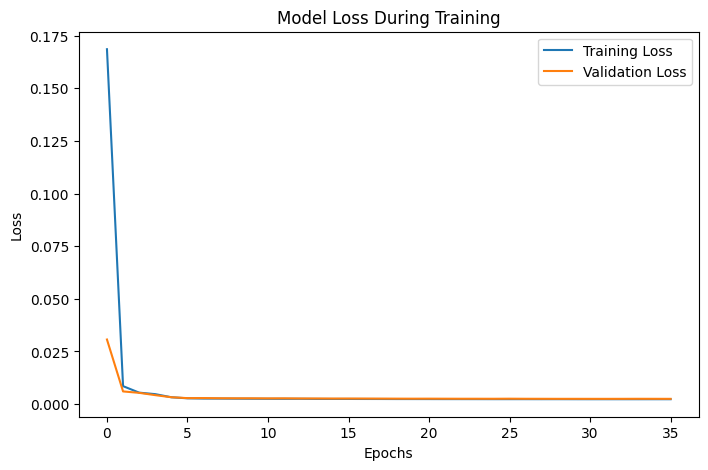

In [240]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [241]:
train_reconstructions = autoencoder.predict(X_train)
train_loss = np.mean(np.square(X_train - train_reconstructions), axis=(1, 2))

test_reconstructions = autoencoder.predict(X_test)
test_loss = np.mean(np.square(X_test - test_reconstructions), axis=(1, 2))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [242]:
print(f"\nTrain MSE: {train_loss}")
print(f"\nTest MSE: {test_loss}")


Train MSE: [0.00114252 0.00116855 0.00150501 ... 0.00703037 0.00723957 0.00696866]

Test MSE: [0.00111265 0.00106838 0.00104137 0.00106218 0.00107152 0.00106796
 0.00107401 0.00106436 0.00126878 0.00178907 0.00182279 0.00196986
 0.00194562 0.00186316 0.00187225 0.00184637 0.00177487 0.00173886
 0.00171124 0.00183264 0.00182671 0.00193212 0.00166138 0.00174442
 0.00179383 0.00166688 0.00151206 0.00144559 0.00148785 0.00148913
 0.00163546 0.00169201 0.00167805 0.00149279 0.00151521 0.00151219
 0.00151929 0.00142928 0.0014238  0.0013851  0.00139628 0.00143416
 0.00145786 0.00158867 0.00207486 0.00184258 0.00201853 0.00197271
 0.00188704 0.00192179 0.00176162 0.00174808 0.00174355 0.00176132
 0.00177058 0.0016557  0.00156852 0.00158813 0.00162187 0.00143247
 0.00151853 0.00126521 0.00131249 0.00128066 0.00147978 0.00156571
 0.00158359 0.00159087 0.00154413 0.00160076 0.00148542 0.00155119
 0.0017265  0.00172515 0.00159459 0.00194413 0.00146469 0.00144631
 0.00143308 0.0014524  0.00159967 

In [243]:
threshold = np.percentile(train_loss, 80)
print(f"Anomaly Detection Threshold: ",threshold)

Anomaly Detection Threshold:  0.0022733239135691247


In [244]:
anomalies = test_loss > threshold

test_dates = data['date'][-len(test_data):].reset_index(drop=True)
valid_test_dates = test_dates[sequence_length:]
anomalous_dates = valid_test_dates[anomalies]

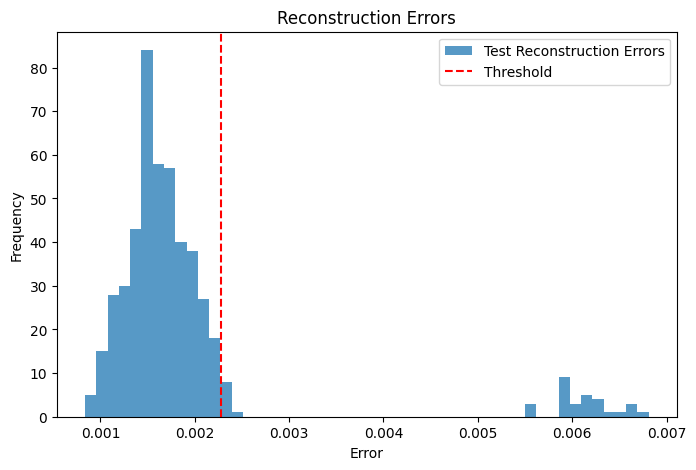

In [245]:
plt.figure(figsize=(8, 5))
plt.hist(test_loss, bins=50, alpha=0.75, label='Test Reconstruction Errors')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

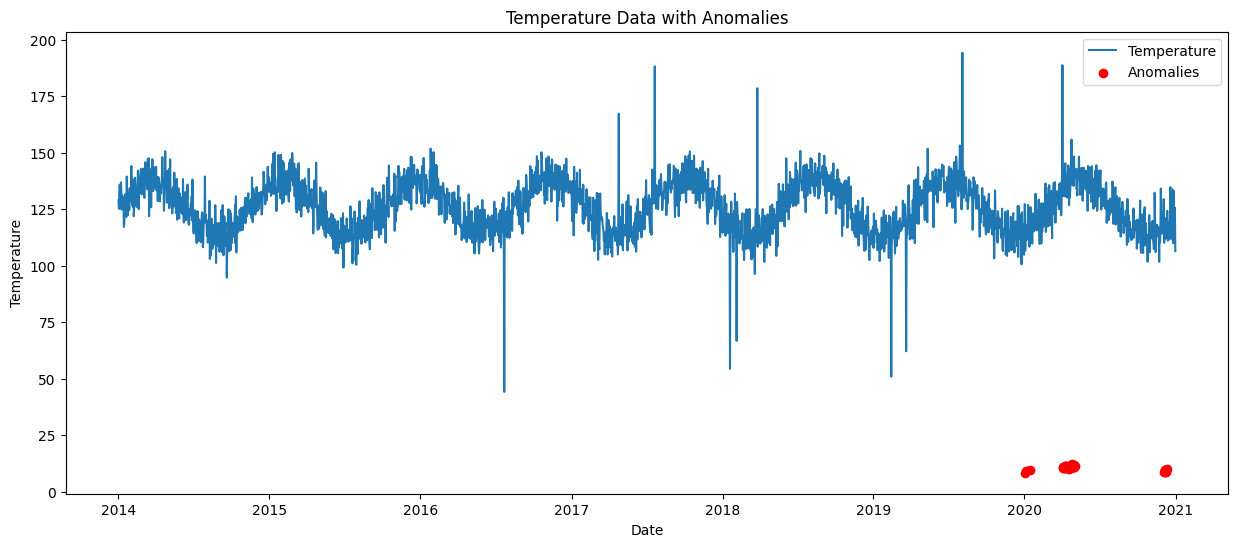

In [246]:
plt.figure(figsize=(15, 6))
plt.plot(data['date'], scaler.inverse_transform(data['temperature'].values.reshape(-1, 1)), label='Temperature')

# Checking if anomalies contains any True values and sequence_length is valid
if np.any(anomalies) and sequence_length < len(test_data):
    # Checking if slicing operation results in empty array
    anomalous_data = test_data[sequence_length:][anomalies]

    if anomalous_data.size > 0:
        plt.scatter(anomalous_dates, scaler.inverse_transform(anomalous_data.reshape(-1, 1)),
                    color='red', label='Anomalies')
    else:
        print("Warning: Slicing operation resulted in an empty array. No anomalies to plot.")
else:
    print("Warning: No anomalies detected or invalid sequence_length.")

plt.title("Temperature Data with Anomalies")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()